In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import seaborn as sns   


In [54]:

import h2o

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 9 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,11 days
H2O cluster name:,laisima
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [55]:
train = pd.read_csv('train.csv')

In [56]:
test = pd.read_csv('train.csv')

In [57]:
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [58]:
missing=train.isnull().sum()
missing=missing[missing>0]

In [59]:
train.shape
# This is a 1460 rows, 81 columns dataset.

(1460, 81)

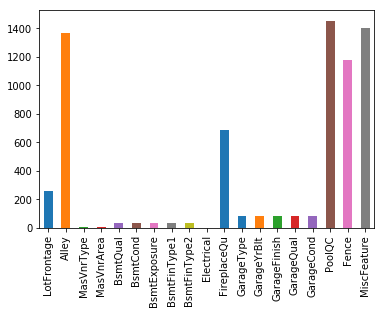

In [60]:
missing
missing.plot.bar()
#missing value summarize
#We have the following missing values that count over 70% of the sum of the whole dataset: 
#Alley, PoolQC, Fence, MiscFeature, and half of the FireplaceQu items are missing. 
# Since there are instances without fireplaces, Pools, Fence, and other Misllaneous features,
# We should treat NA in Fireplace Quality, fireplaces, pools, fence, and misllaneous as a new category once we gonna use them. 




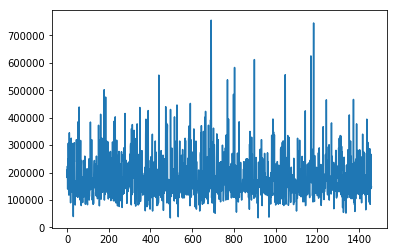

In [61]:
train['SalePrice'].describe()
train['SalePrice'].plot()

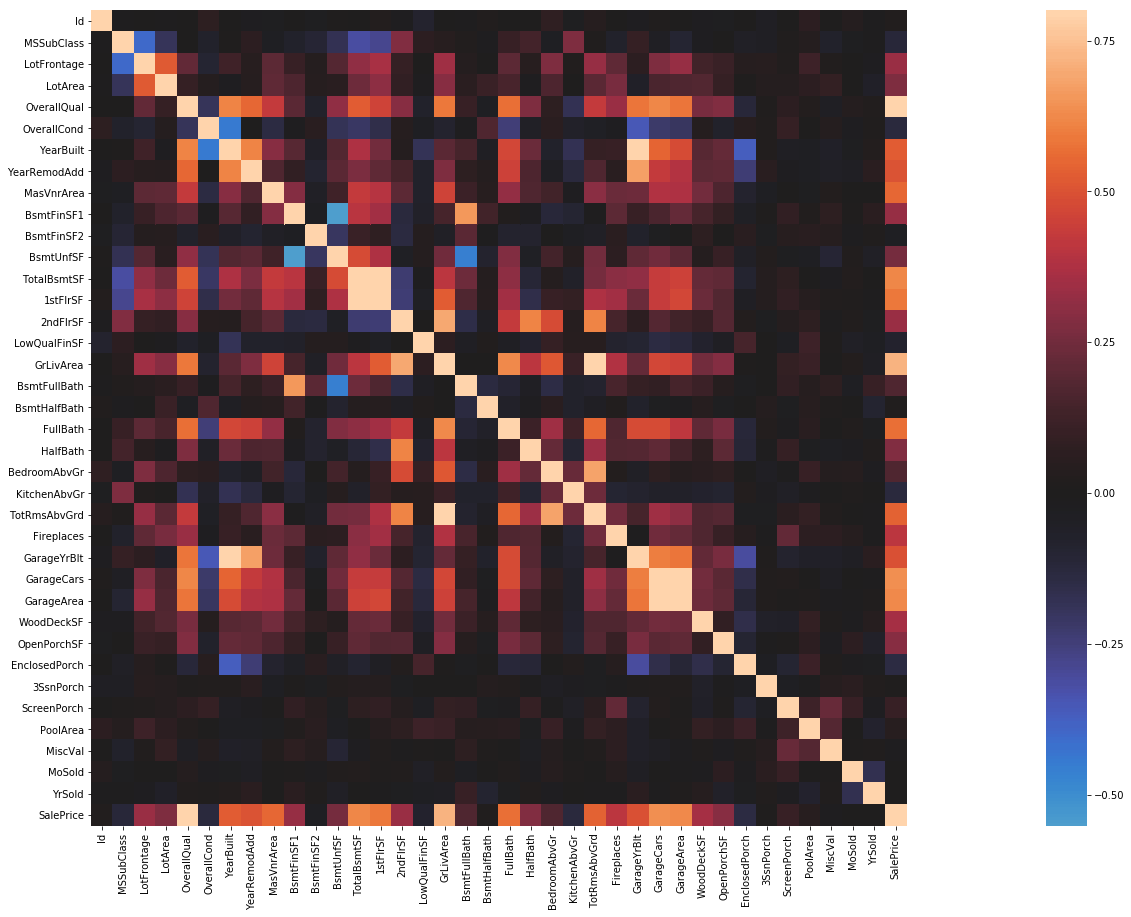

In [82]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(50, 15))
sns.heatmap(corrmat, vmax=0.8, square=True,center=0)
# This is the heatmap for the quantitive variables showing the relationship of them.
# The black square means they have a very weak realtionship, We will discard the weak points to make a better performance.
# We gonna pick LotFrontage, LotArea, OveralQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtUnfSF,TotalBsmtSF, 1stFlrSF,2ndFlrSF,GrLivArea,BsmtHalfBath,FullBath,HalfBath,Bedroom,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars, GarageArea,WoodDeckSF,OpenPorchSF.  

In [64]:
h2otrain = h2o.H2OFrame(train)
h2otrain, h2ovalid = h2otrain.split_frame([0.7], seed=12345)
train = h2otrain.as_data_frame()
valid = h2ovalid.as_data_frame()

In [97]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
4,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000


In [112]:


cols = ['LotFrontage','LotArea','OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea','BsmtFinSF1', 'BsmtUnfSF','TotalBsmtSF', '1stFlrSF','2ndFlrSF','GrLivArea','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars', 'GarageArea','WoodDeckSF','OpenPorchSF']



In [113]:
cols

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

In [121]:
x = train[cols]
x=x.fillna(0)
# Since the original NA value in LotFrontage means there is no Frontage in the house, so we should change NA value to 0.

In [128]:

x

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,65.0,8450,7,5,2003,2003,196.0,706,150,856,...,2,1,3,8,0,2003.0,2,548,0,61
1,80.0,9600,6,8,1976,1976,0.0,978,284,1262,...,2,0,3,6,1,1976.0,2,460,298,0
2,68.0,11250,7,5,2001,2002,162.0,486,434,920,...,2,1,3,6,1,2001.0,2,608,0,42
3,85.0,14115,5,5,1993,1995,0.0,732,64,796,...,1,1,1,5,0,1993.0,2,480,40,30
4,75.0,10084,8,5,2004,2005,186.0,1369,317,1686,...,2,0,3,7,1,2004.0,2,636,255,57
5,51.0,6120,7,5,1931,1950,0.0,0,952,952,...,2,0,2,8,2,1931.0,2,468,90,0
6,85.0,11924,9,5,2005,2006,286.0,998,177,1175,...,3,0,4,11,2,2005.0,3,736,147,21
7,91.0,10652,7,5,2006,2007,306.0,0,1494,1494,...,2,0,3,7,1,2006.0,3,840,160,33
8,0.0,10920,6,5,1960,1960,212.0,733,520,1253,...,1,1,2,5,1,1960.0,1,352,0,213
9,72.0,10791,4,5,1967,1967,0.0,0,0,0,...,2,0,2,6,0,1967.0,2,516,0,0


In [123]:
y = train['SalePrice']

In [129]:
y

0      208500
1      181500
2      223500
3      143000
4      307000
5      129900
6      345000
7      279500
8      157000
9       90000
10     139000
11     325300
12     154000
13     134800
14     306000
15      40000
16     179900
17     165500
18     277500
19     309000
20     109000
21      82000
22     170000
23     130250
24     239686
25     249700
26     113000
27     114500
28     110000
29     130000
        ...  
663    120000
664    275000
665    112000
666    215000
667    230000
668    140000
669    257000
670    207000
671    124000
672    223000
673    274970
674    144000
675    271000
676    140000
677    119000
678    182900
679    192140
680    143750
681     64500
682    186500
683    120500
684    197000
685    149300
686    310000
687    157900
688     92000
689    287090
690     84500
691    175000
692    210000
Name: SalePrice, Length: 693, dtype: int64

In [130]:
h2otrain = h2o.H2OFrame(x)
h2otrain, h2ovalid = h2otrain.split_frame([0.7], seed=12345)
htrain = h2otrain.as_data_frame()
hvalid = h2ovalid.as_data_frame()